In [24]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

In [25]:
def tank_improved(z,t,min,tin,cp,q,rho,g,r,a):
    h = z[0]
    te = z[1]
    dhdt = (1/a) * ((min/rho) - (rho*g*h/r))
    dTdt = (min/(rho*rho*g*h/r))*tin - te + q/(cp*(rho*rho*g*h/r))
    dzdt = [dhdt,dTdt]
    return dzdt


In [26]:
# heater model parameters
t = np.linspace(0,200,1000)

tin = 293.15
q = 150000
cp = 4.2

# tank model parameters 
min = 3000.0
h0 = 6
rho = 1000
r = 20000
a = np.pi * 1.5**2
g = 9.8

In [27]:
### TEST MODEL SETUP ###
# z = odeint(tank_improved,z0,t,args=(min,tin,cp,q,rho,g,r,a,))
# h = z[:,0]
# te = z[:,1]
# te = te - 273.15
# print(z)

In [28]:
z0 = [h0,tin]
h=np.zeros(len(t))
te=np.zeros(len(t))
h[0] = h0
te[0] = tin
for i in range (len(t)-1):
    z = odeint(tank_improved,z0,[t[i],t[i+1]],args=(min,tin,cp,q,rho,g,r,a,))
    z0 = z[1]
    print(z[1])
    h[i+1] = z[1,0]
    te[i+1] = z[1,1]
te = te - 273.15

[  6.00168761 296.43121975]
[  6.00335197 299.10135484]
[  6.00499339 301.27150219]
[  6.00661218 303.03259868]
[  6.00820867 304.45907898]
[  6.00978315 305.61186919]
[  6.01133593 306.54083913]
[  6.01286731 307.28680659]
[  6.01437758 307.88318073]
[  6.01586704 308.3573061 ]
[  6.01733598 308.73156236]
[  6.01878466 309.02426753]
[  6.02021338 309.25041215]
[  6.02162241 309.42226423]
[  6.02301202 309.54986327]
[  6.02438248 309.64142442]
[  6.02573405 309.7036695 ]
[  6.027067   309.74209807]
[  6.02838157 309.76120923]
[  6.02967802 309.76468319]
[  6.03095661 309.75553035]
[  6.03221757 309.7362123 ]
[  6.03346116 309.70874135]
[  6.03468761 309.67476211]
[  6.03589715 309.63561832]
[  6.03709003 309.59240745]
[  6.03826646 309.54602549]
[  6.03942668 309.49720355]
[  6.04057091 309.44653781]
[  6.04169937 309.39451398]
[  6.04281228 309.34152748]
[  6.04390985 309.28789987]
[  6.04499229 309.23389229]
[  6.04605982 309.17971646]
[  6.04711263 309.1255468 ]
[  6.04815093 309.07

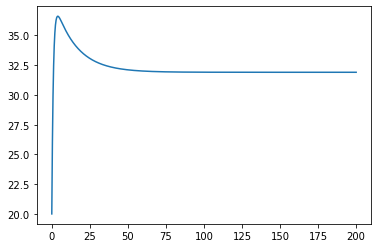

In [29]:
plt.plot(t,te)
plt.show()

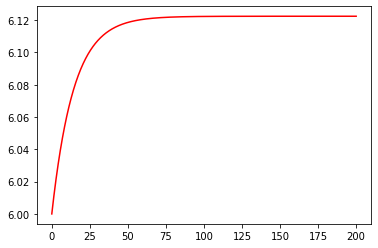

In [30]:
plt.plot(t,h,'r-')
plt.show()